In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# download and load the Cifar-10 dataset

# what is the effect of normalizing?
#transform = transforms.Compose([transforms.ToTensor(), 
#                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.ToTensor()])

train = torchvision.datasets.CIFAR10('./', train=True, download=True,
                                    transform=transform)

test = torchvision.datasets.CIFAR10('./', train=False, download=True,
                                    transform=transform)

trainset = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True, num_workers=2)
testset = torch.utils.data.DataLoader(test, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# class labels
# the labels are in b'' string format
import pickle
with open("cifar-10-batches-py/batches.meta", "rb") as file:
    classes = pickle.load(file, encoding="bytes")[b"label_names"]
classes = [str(cifar_class, "utf-8") for cifar_class in classes]
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


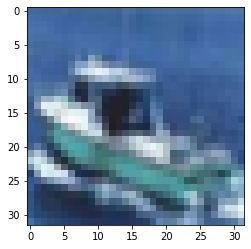

ship


In [4]:
# let's grab one image along with its label
for data in trainset:
    break
# x: pixel values (tensor)
# y: its label (tensor)
x, y = data[0][3], data[1][3]

plt.imshow(np.transpose(x.numpy(), (1, 2, 0)))
plt.show()
print(classes[y.item()])

In [5]:
# neural network class
class Cifar10Classifier(nn.Module):
    
    def __init__(self):
        super().__init__()

        # layers:
        # first two layers are convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)

        self.pool = nn.MaxPool2d(2, 2)
        
        # after the convolutional layers we need to map back to
        # linear layers (fully  connected layers) 
        self.fc1 = nn.Linear(32*8*8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # feed forward: input (image) ---> output (predicted class label)
    def forward(self, X):
        # 1. pass through conv layer
        # 2. activation function (ReLU)
        # 3. Max pooling over a (2, 2) window
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        
        # flatten
        X = X.view(-1, 32*8*8)
        
        # Fully connected layers with activation function
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        
        # finally map to labels
        X = self.fc3(X)
        return X

In [6]:
# Set path for saving the model weights
PATH = "./cifar_net.pth"

In [ ]:
# Use CUDA GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    net = Cifar10Classifier().to(device)

net = Cifar10Classifier()

# loss function
loss_function = nn.CrossEntropyLoss()
# Optimizer used for backpropagation
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [7]:
# Training!
EPOCHS = 1
for epoch in range(EPOCHS):
    
    running_loss = 0.0
    for i, data in enumerate(trainset, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # 1. forward; 2. backward; 3. optimize
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{epoch+1}, {i+1}] loss: {running_loss/2000}")
            running_loss = 0.0
            
print("Saving...")
# Saving the trained model
torch.save(net.state_dict(), PATH)
print("Finished!")

[1, 2000] loss: 1.8331288377642632
[1, 4000] loss: 1.490411402836442
[1, 6000] loss: 1.3741659685224294
[1, 8000] loss: 1.2932234476208686
[1, 10000] loss: 1.235905463606119
[1, 12000] loss: 1.1804459452927112
Finished!


In [8]:
# Loading previously saved model
net = Cifar10Classifier()

if torch.cuda.is_available():
    net.load_state_dict(torch.load(PATH))
    net.to(device)
else:
    net.load_state_dict(torch.load(PATH, map_location="cpu"))

In [9]:
# Test with test dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testset:
        if torch.cuda.is_available():
            images, labels = data[0].to(device), data[1].to(device)
        else:
            images, labels = data
        '''
        plt.imshow(np.transpose(torch.Tensor.cpu(images[0]).numpy(), (1, 2, 0)))
        plt.show()
        print(classes[labels[0].item()])
        '''
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # print(classes[predicted[0].item()])
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f"Accuracy of the network: {100 * correct / total}%")
print(f"correct: {correct}")
print(f"total: {total}")

Accuracy of the network: 59.56%
correct: 5956
total: 10000


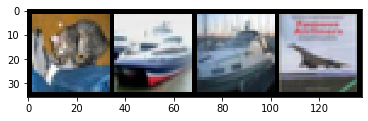

['cat', 'ship', 'ship', 'airplane']


In [10]:
dataiter = iter(testset)
images, labels = dataiter.next()

img = torchvision.utils.make_grid(images)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

print([classes[labels[j]] for j in range(4)])

In [12]:
if torch.cuda.is_available():
    images.to(device)
    
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print([classes[predicted[j]] for j in range(4)])

['dog', 'ship', 'ship', 'ship']
